The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


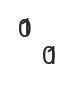

In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

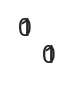

In [14]:
sns.set_palette(NEWPAL)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

In [15]:
FIGDIR = '../../../writing/230131_cedar_paper_1/figures/'

# init

## reloading datasets

In [16]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()
cedar_aligned = pd.read_csv('../data/aligned_icore/230125_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230125_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230125_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230125_nepdb_aligned_icore.csv')
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


0.5784313725490196

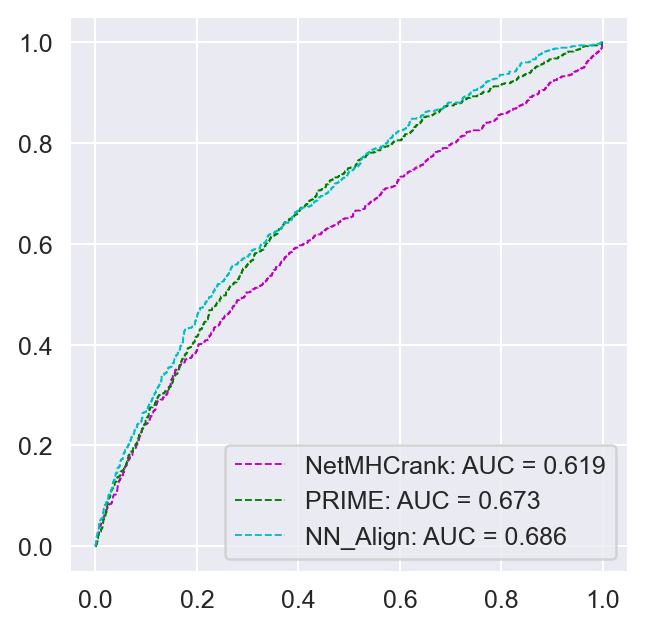

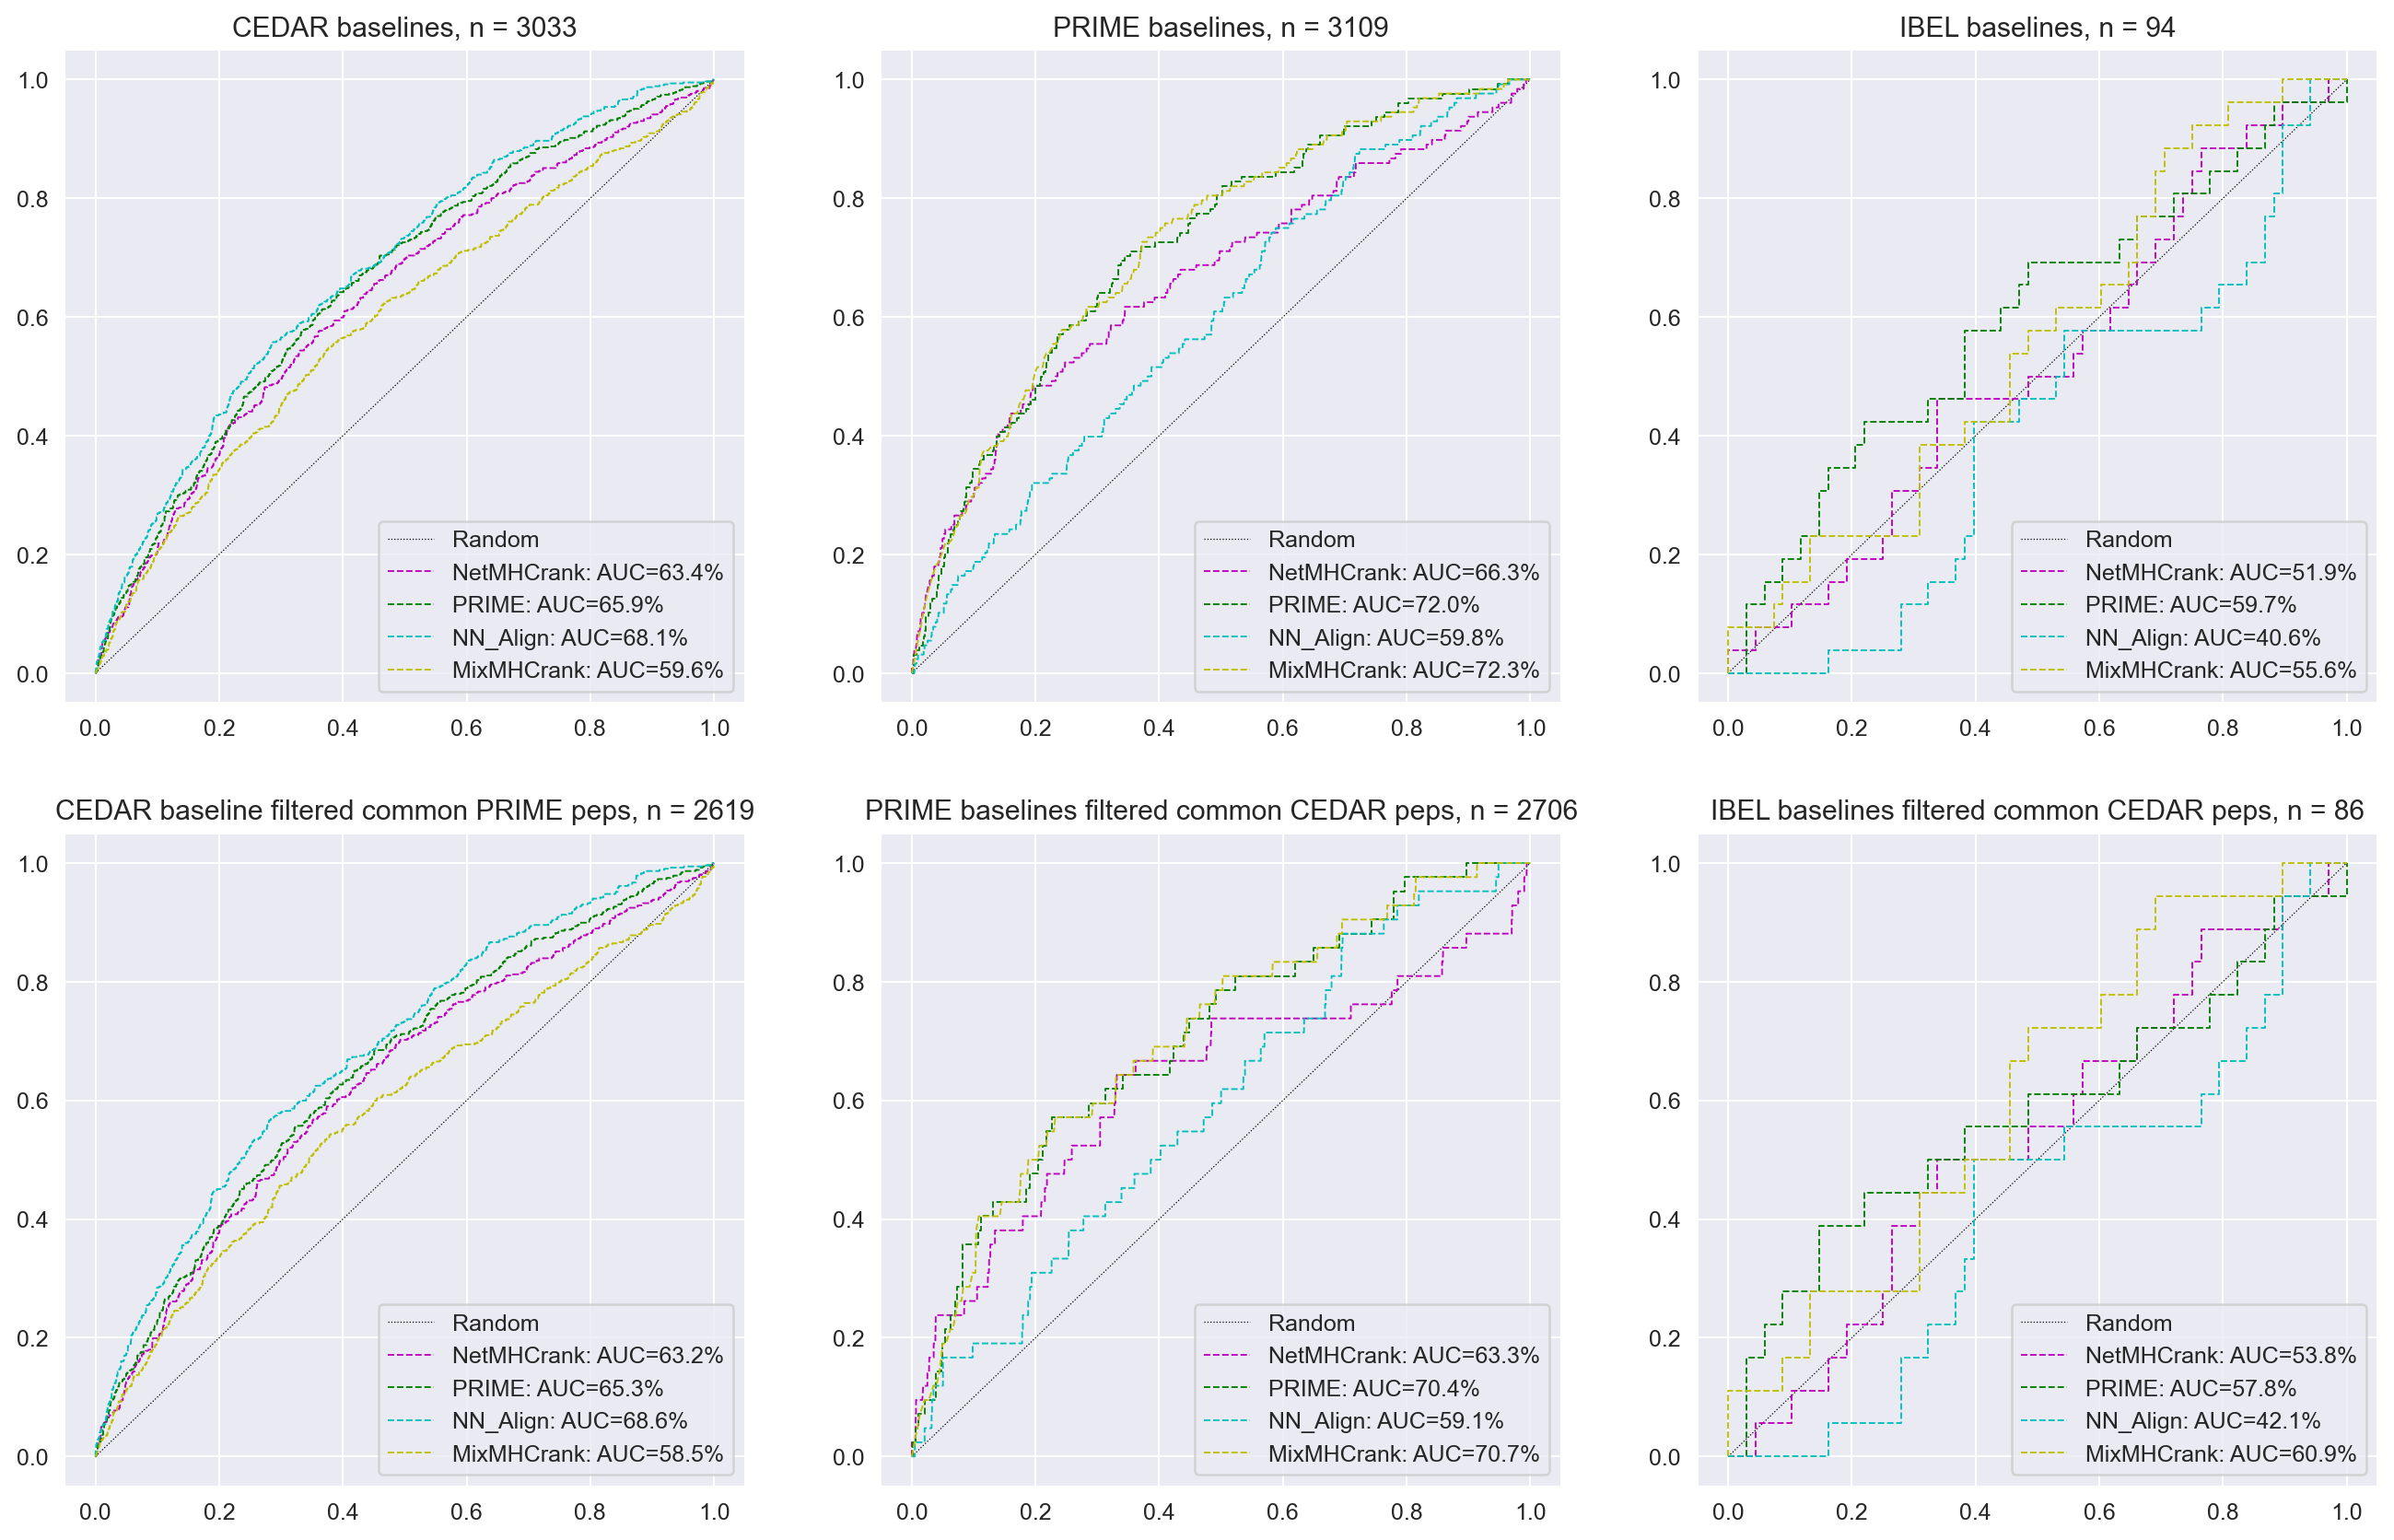

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)
a.legend()

from src.baselines import plot_related_baseline_roc
cpeps = cedar_related_baseline.Peptide.values
ppeps = prime_related_baseline.Peptide.values
cp_common_peps = [x for x in cpeps if x in ppeps]
len(ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')), len(ibel)

f,a = plt.subplots(2,3, figsize=(18,11.25))
a = a.ravel()
plot_related_baseline_roc(a[0], dataset=cedar_related_baseline)
plot_related_baseline_roc(a[1], dataset=prime_related_baseline)
plot_related_baseline_roc(a[2], dataset=ibel)

plot_related_baseline_roc(a[3], dataset=cedar_related_baseline.query('Peptide not in @ppeps'))
plot_related_baseline_roc(a[4], dataset=prime_related_baseline.query('Peptide not in @cpeps'))
plot_related_baseline_roc(a[5], dataset=ibel.query('Peptide not in @cpeps and Peptide not in @ppeps'))

a[0].set_title(f'CEDAR baselines, n = {len(cedar_related_baseline)}')
a[1].set_title(f'PRIME baselines, n = {len(prime_related_baseline)}')
a[2].set_title(f'IBEL baselines, n = {len(ibel)}')
a[3].set_title(f'CEDAR baseline filtered common PRIME peps, n = {len(cedar_related_baseline.query("Peptide not in @ppeps"))}')
a[4].set_title(f'PRIME baselines filtered common CEDAR peps, n = {len(prime_related_baseline.query("Peptide not in @cpeps"))}')
a[5].set_title(f'IBEL baselines filtered common CEDAR peps, n = {len(ibel.query("Peptide not in @cpeps and Peptide not in @ppeps"))}')

a[0].legend(loc = 'lower right')
a[1].legend(loc = 'lower right')
a[2].legend(loc = 'lower right')
a[3].legend(loc = 'lower right')
a[4].legend(loc = 'lower right')
a[5].legend(loc = 'lower right')

cols = ['HLA', 'agg_label', 'Peptide', 'wild_type', 'Peptide_mut', 'Peptide_wt', 'icore_mut', 'icore_wt', 'core_wt', 'core_mut', 'EL_rank_mut', 'EL_rank_wt']
tmp = ibel.query('Peptide not in @cpeps and Peptide not in @ppeps')
roc_auc_score(tmp['agg_label'], tmp['PRIME_score'])

# Exploration

In [6]:
from src.metrics import get_metrics
from sklearn.metrics import matthews_corrcoef

In [7]:
np.linspace(0.05, .95, 25)

array([0.05  , 0.0875, 0.125 , 0.1625, 0.2   , 0.2375, 0.275 , 0.3125,
       0.35  , 0.3875, 0.425 , 0.4625, 0.5   , 0.5375, 0.575 , 0.6125,
       0.65  , 0.6875, 0.725 , 0.7625, 0.8   , 0.8375, 0.875 , 0.9125,
       0.95  ])

In [8]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    return best[0], best[1]

# Example
preds_df = pd.read_csv('../output/221122_mutscore_cedar_fixed/raw/cedar_preds_onehot_None_icore_mut_EL_rank_mut_aa_props.csv')

t_list = []
mcc_list = []
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    
np.mean(mcc_list), np.mean(t_list)


Current fold : 0
	Best : Threshold= 0.350, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.275, MCC= 0.298

Current fold : 2
	Best : Threshold= 0.162, MCC= 0.154

Current fold : 3
	Best : Threshold= 0.200, MCC= 0.323

Current fold : 4
	Best : Threshold= 0.275, MCC= 0.453

Current fold : 5
	Best : Threshold= 0.200, MCC= 0.382

Current fold : 6
	Best : Threshold= 0.387, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.237, MCC= 0.325

Current fold : 8
	Best : Threshold= 0.312, MCC= 0.286

Current fold : 9
	Best : Threshold= 0.312, MCC= 0.277


(0.31972651124419793, 0.27125000000000005)

In [9]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.ensemble import RandomForestClassifier

cedar_trainset = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_evalset = pd.read_csv('../data/mutant/221117_prime_related_newcore_fold.csv')
ibel_evalset = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')

_, aa_cols = get_aa_properties(cedar_trainset.sample(1))
# Shannon for first 3
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['dissimilarity_score', 'blsm_mut_score'])

for k, ics_dict, best_kwargs in zip(['Compromise'],
                                   [ics_kl],
                                   [best_agg]):
    
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)
    
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_trainset, model, ics_dict, best_kwargs, n_jobs=8)
    kcv_preds, _ = evaluate_trained_models_sklearn(cedar_trainset, trained_models, ics_dict, train_dataframe=cedar_trainset,
                                                encoding_kwargs = best_kwargs, concatenated = False, n_jobs=8)
    break

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
def threshold_pred(df, thresholds, predcol, targetcol):
    df = df.copy()
    df['predicted_label'] = np.nan
    for k in df.fold.unique():
        tmp = df.query('fold==@k')
        preds = (tmp[predcol]>=thresholds[k]).astype(int)
        df.loc[tmp.index, 'predicted_label'] = preds
    return df

thresholds = {}
for f in sorted(preds_df.fold.unique()):
    print(f'\nCurrent fold : {f}')
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 50, 'pred', 'agg_label')
    thresholds[f] = t
thresholded_df = threshold_pred(preds_df, thresholds, 'pred', 'agg_label')


Current fold : 0
	Best : Threshold= 0.344, MCC= 0.333

Current fold : 1
	Best : Threshold= 0.289, MCC= 0.312

Current fold : 2
	Best : Threshold= 0.160, MCC= 0.172

Current fold : 3
	Best : Threshold= 0.215, MCC= 0.318

Current fold : 4
	Best : Threshold= 0.270, MCC= 0.446

Current fold : 5
	Best : Threshold= 0.215, MCC= 0.388

Current fold : 6
	Best : Threshold= 0.381, MCC= 0.366

Current fold : 7
	Best : Threshold= 0.252, MCC= 0.312

Current fold : 8
	Best : Threshold= 0.289, MCC= 0.308

Current fold : 9
	Best : Threshold= 0.307, MCC= 0.277


In [11]:
from sklearn.metrics import precision_score, f1_score, recall_score
print('per fold thresholding\n', 
      f"F1:\t{round(f1_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nPrec:\t{round(precision_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
       f"\nRecall:\t{round(recall_score(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(thresholded_df['agg_label'], thresholded_df['predicted_label']),4)}")
print('\nmean_thresholding\n', 
      f"F1:\t{round(f1_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nPrec:\t{round(precision_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
       f"\nRecall:\t{round(recall_score(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}",
      f"\nMCC:\t{round(matthews_corrcoef(kcv_preds['agg_label'], (kcv_preds['mean_pred']>=np.mean([v for _,v in thresholds.items()])).astype(int)),4)}")

per fold thresholding
 F1:	0.4557 
Prec:	0.3974 
Recall:	0.5341 
MCC:	0.2906


KeyError: 'agg_label'

# Check AUC per fold (with concat)

## checks

In [ ]:
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    for t in thresholds:
        preds = scores > t
        results[t] = matthews_corrcoef(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    print(f'\tBest : Threshold= {best[0]:.3f}, MCC= {best[1]:.3f}')
    threshold, mccoef = best[0], best[1]
    return threshold, mccoef

In [ ]:
compromise = pd.read_csv('../output/230125_aligned_icore_mutscore/raw/CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score.csv')

t_list = []
mcc_list = []
new_preds = preds_df.copy()
for f in preds_df.fold.unique():
    print(f'\nCurrent fold : {f}')
    print(preds_df.query('fold==@f').pred.median())
    t, mcc = tune_threshold(preds_df.query('fold==@f'), 25, 'pred', 'agg_label')
    t_list.append(t)
    mcc_list.append(mcc)
    idx = new_preds.query('fold==@f').index
    new_preds.loc[idx, 'pred']=new_preds.loc[idx,'pred']-t
np.mean(mcc_list), np.mean(t_list)

In [ ]:
roc_auc_score(new_preds['agg_label'], new_preds['pred']), roc_auc_score(preds_df['agg_label'], preds_df['pred'])

In [ ]:
f,a = plt.subplots(len(compromise.fold.unique()), 1, figsize=(10, 5*len(compromise.fold.unique())))
compromise.groupby(['fold'])['mean_pred'].plot(kind='hist', alpha=0.75, bins=60)

## Retrain model

In [46]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')

In [47]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total Gene TPM'])

best_models_retrained = {}

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)

trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model, None, best_agg, n_jobs=8)
cv_metrics, cv_preds = evaluate_trained_models_sklearn(cedar_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg)
metrics, preds = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=True, encoding_kwargs=best_agg)

metrics_mean, preds_mean = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=False, only_concat=False, encoding_kwargs=best_agg)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
roc_auc_score(preds['agg_label'], preds['pred']), roc_auc_score(preds_mean['agg_label'], preds_mean['mean_pred'])

In [ ]:
from src.utils import get_palette
sns.set_palette(get_palette('viridis', n_colors=10))
cv_preds.groupby('fold')['pred'].plot(kind='hist', alpha=0.75, bins = 100, legend=True)
pd.set_option('display.max_columns',40)
cv_preds[['HLA','agg_label','fold','Peptide','pred']].groupby('fold')['agg_label','pred'].describe(percentiles = [.1, .25, .5, .75, .8, .9, .95])

In [ ]:


print('For CEDAR KCV')
for k in metrics:
    print(k, round(cv_metrics[k]['auc'],3), round(cv_metrics[k]['auc_01'],3), round(cv_metrics[k]['AP'],3))
    
cv_mean_xd = preds.groupby(['Peptide','agg_label','HLA'])[['pred']].mean().reset_index()
print('mean', round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred']),3), round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred'], max_fpr=0.1),3), round(average_precision_score(mean_xd['agg_label'], mean_xd['pred']),3)) 


print('For prime aligned')
for k in metrics:
    print(k, round(metrics[k]['auc'],3), round(metrics[k]['auc_01'],3), round(metrics[k]['AP'],3))
    
mean_xd = preds.groupby(['Peptide','agg_label','HLA'])[['pred']].mean().reset_index()
print('mean', round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred']),3), round(roc_auc_score(mean_xd['agg_label'], mean_xd['pred'], max_fpr=0.1),3), round(average_precision_score(mean_xd['agg_label'], mean_xd['pred']),3)) 



## checks

In [23]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total Gene TPM'])

def print_stuff(labels, scores, threshold):
    mcc_notune = matthews_corrcoef(labels, scores>0.19)
    prec_notune = precision_score(labels, scores>0.19)
    rec_notune = recall_score(labels, scores>0.19)
    acc_notune = balanced_accuracy_score(labels, scores>0.19)
    f1_notune = f1_score(labels, scores>0.19)
    mcc_tuned = matthews_corrcoef(labels, scores>threshold)
    prec_tuned = precision_score(labels, scores>threshold)
    rec_tuned = recall_score(labels, scores>threshold)
    acc_tuned = balanced_accuracy_score(labels, scores>threshold)
    f1_tuned = f1_score(labels, scores>threshold)
    # mcc_diff = mcc_tuned-mcc_notune
    # prec_diff = prec_tuned-prec_notune
    # rec_diff = rec_tuned-rec_notune
    # f1_diff = f1_tuned-f1_notune
    # acc_diff = acc_tuned-acc_notune
    print(f'No tune (T=0.19): \tMCC={mcc_notune:.3f}, prec={prec_notune:.2%}, recall={rec_notune:.2%}, f1={f1_notune:.2%}, acc={acc_notune:.2%}')
    print(f'Best : T={threshold:.3f}, \tMCC={mcc_tuned:.3f}, prec={prec_tuned:.2%}, recall={rec_tuned:.2%}, f1={f1_tuned:.2%}, acc={acc_tuned:.2%}')
    # print(f'Best threshold={threshold:.3f}, \t∂MCC= {mcc_diff:.2%}, ∂prec= {prec_diff:.2%}, ∂rec= {rec_diff:.2%}, ∂F1= {f1_diff:.2%}, ∂Acc= {acc_diff:.2%}')
    
def tune_threshold(df, n_points=25, predcol='pred', targetcol='agg_label'):
    thresholds = np.linspace(0.05, 0.95, n_points)
    results = {}
    labels = df[targetcol].astype(int)
    scores = df[predcol].astype(float)
    
    for t in thresholds:
        preds = scores > t
        results[t] = f1_score(labels, preds)
        # print(f'{t}: {results[t]}')
    best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
    threshold, best_score = best[0], best[1]
    print_stuff(labels,scores,threshold)
    return threshold, best_score

In [24]:
for f in sorted(cv_preds.fold.unique()):
    print('Fold: ',f)
    tune_threshold(cv_preds.query('fold==@f'))
print('Concat:')
tune_threshold(cv_preds)

NameError: name 'cv_preds' is not defined

In [ ]:
import copy
kwargs = copy.deepcopy(best_agg)
res = {}

folds = sorted(cv_preds.fold.unique())
concat = []
for outer_fold in folds:
    for i, inner_fold in enumerate(sorted([f for f in folds if f != outer_fold])):
        df = cv_preds.query('fold==@inner_fold')
        x, y = get_dataset(df, None, **kwargs)
        model = trained_models[outer_fold][i]
        res[i] = pd.DataFrame(np.array([y, model.predict_proba(x)[:, 1]]).T, columns=['agg_label', 'pred'])
        print('\nFolds: ', outer_fold, inner_fold)
        tune_threshold(res[i], n_points=50)
        concat.append(res[i])
print('CONCAT')
tune_threshold(pd.concat(concat), n_points=50)

# Redo with two methods and classes

## Retrain model

In [46]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_aligned_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_aligned_pepx.csv').query('Peptide not in @cedar_aligned.Peptide.values')

In [47]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from sklearn.ensemble import RandomForestClassifier
from src.data_processing import get_aa_properties, AA_KEYS
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, balanced_accuracy_score, accuracy_score, f1_score, average_precision_score

# Compromise model
best_agg = dict(max_len=12, encoding='onehot', blosum_matrix=None, mask = False, add_rank=True, invert=False,
                  add_aaprop=False, remove_pep=False, standardize=True, target_col = 'agg_label', seq_col ='icore_mut', 
                rank_col='EL_rank_mut', hla_col ='HLA', 
                mut_col = ['icore_dissimilarity_score', 'icore_blsm_mut_score', 'Total Gene TPM'])

best_models_retrained = {}

model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300, max_depth=8, ccp_alpha=9.945e-6)

trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_expr, model, None, best_agg, n_jobs=8)
cv_metrics, cv_preds = evaluate_trained_models_sklearn(cedar_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg)
metrics, preds = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=True, encoding_kwargs=best_agg)

metrics_mean, preds_mean = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, 
                                                 concatenated=False, only_concat=False, encoding_kwargs=best_agg)

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

In [48]:
def get_scores(scores, labels, threshold=0.5):
    results={}
    results['auc'] = round(roc_auc_score(labels, scores), 4)
    results['auc01'] = round(roc_auc_score(labels, scores, max_fpr=0.1), 4)
    results['ap'] = round(average_precision_score(labels, scores), 4)
    preds = scores>threshold
    results['balanced_acc'] = round(balanced_accuracy_score(labels, preds), 4)
    results['acc'] = round(accuracy_score(labels, preds), 4)
    results['prec'] = round(precision_score(labels, preds), 4)
    results['rec'] = round(recall_score(labels, preds), 4)
    results['f1'] = round(recall_score(labels, preds), 4)
    fpr, tpr, _ = roc_curve(labels, scores)
    rocs = (fpr,tpr)
    return results, rocs

In [ ]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing

class OuterFoldWrapper():
    def __init__(self, models_dict, train_df, scoring):
        self.models = models_dict
        self.train_df = train_df
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        
    def tune_threshold(self, df, n_points=100, predcol='pred', labelcol = 'agg_label'):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = df[predcol].values
        labels = df[labelcol].values        
        results = {t:self.scoring(labels, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        
        return threshold, score

    def tune_all_thresholds(self, n_points=100, predcol='pred', target_col='agg_label'):
        # This is done using outerfold and all models in inner fold, i.e. doesn't need the x,y but only 
        for fold in self.models:
            threshold, score = self.tune_threshold(self.train_df.query('fold==@fold'), n_points, predcol, target_col)
            self.thresholds[fold] = threshold
            self.scores[fold] = score
        self.tuned=True
            
        
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([(np.mean(([model.predict_proba(x)[:, 1] for model in self.models[k]]), axis=0)>self.thresholds[k]).astype(int) for k in self.models], axis=0)

    
class AllFoldWrapper():
    def __init__(self, models_dict, train_df, ics_dict,  kwargs, scoring, cores=multiprocessing.cpu_count()):
        self.models = models_dict
        self.train_df = train_df
        self.folds = sorted(train_df.fold.unique())
        self.ics_dict = ics_dict
        self.kwargs = kwargs
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        self.max_cores = cores
        
    def tune_threshold(self, model, x, y, n_points=100):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = model.predict_proba(x)[:, 1]
        results = {t:self.scoring(y, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        return threshold, score
    
    def parallel_wrapper(self, outer_fold, inner_fold, inner_fold_index, n_points=100):
        model = self.models[outer_fold][inner_fold_index]
        x,y = get_dataset(self.train_df.query('fold==@inner_fold'), self.ics_dict, **self.kwargs)
        return self.tune_threshold(model=model, x=x, y=y, n_points=n_points)
    
    def tune_all_thresholds(self, n_points=100, n_jobs=8):
        for outer_fold in tqdm(self.folds, desc='Tuning thresholds: outer fold', leave=False):
            inner_folds = sorted([f for f in self.folds if f!=outer_fold])
            wrapper = partial(self.parallel_wrapper, outer_fold = outer_fold, n_points = n_points)
            output = Parallel(n_jobs=min(n_jobs, self.max_cores))(delayed(wrapper)(inner_fold = fold, inner_fold_index=i) for i, fold in enumerate(inner_folds))
            self.thresholds[outer_fold] = [x[0] for x in output]
            self.scores[outer_fold] = [x[1] for x in output]
        
        self.tuned=True
            
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([np.mean([model.predict_proba(x)[:, 1]>self.thresholds[k][i] for i, model in enumerate(self.models[k])], axis=0) for k in self.models], axis=0)

In [26]:
best_agg['standardize']=True

results_prime = {}
results_nepdb = {}
rocs_prime = {}
rocs_nepdb = {}


In [49]:
_, preds_prime = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg, n_jobs=8)
_, preds_nepdb = evaluate_trained_models_sklearn(nepdb_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=True, encoding_kwargs=best_agg, n_jobs=8)
metrics_prime, rocs_prime_ = get_scores(preds_prime['pred'].values, preds_prime['agg_label'].values, threshold=0.19)
metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb['pred'].values, preds_nepdb['agg_label'].values, threshold=0.19)
results_prime['notune_concat'] = metrics_prime
results_nepdb['notune_concat'] = metrics_nepdb
rocs_prime['notune_concat'] = rocs_prime_
rocs_nepdb['notune_concat'] = rocs_nepdb_

_, preds_prime = evaluate_trained_models_sklearn(prime_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=False, encoding_kwargs=best_agg, n_jobs=8)
_, preds_nepdb = evaluate_trained_models_sklearn(nepdb_expr, trained_models, None, train_dataframe=cedar_expr, concatenated=False, encoding_kwargs=best_agg, n_jobs=8)

metrics_prime, rocs_prime_ = get_scores(preds_prime['mean_pred'].values, preds_prime['agg_label'].values, threshold=0.19)
metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb['mean_pred'].values, preds_nepdb['agg_label'].values, threshold=0.19)
results_prime['notune_mean']= metrics_prime
results_nepdb['notune_mean']= metrics_nepdb
rocs_prime['notune_mean'] = rocs_prime_
rocs_nepdb['notune_mean'] = rocs_nepdb_



Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

## tune-wrapper

In [50]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing

class OuterFoldWrapper():
    def __init__(self, models_dict, train_df, scoring):
        self.models = models_dict
        self.train_df = train_df
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        
    def tune_threshold(self, df, n_points=100, predcol='pred', labelcol = 'agg_label'):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = df[predcol].values
        labels = df[labelcol].values        
        results = {t:self.scoring(labels, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        
        return threshold, score

    def tune_all_thresholds(self, n_points=100, predcol='pred', target_col='agg_label'):
        # This is done using outerfold and all models in inner fold, i.e. doesn't need the x,y but only 
        for fold in self.models:
            threshold, score = self.tune_threshold(self.train_df.query('fold==@fold'), n_points, predcol, target_col)
            self.thresholds[fold] = threshold
            self.scores[fold] = score
        self.tuned=True
            
        
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([(np.mean(([model.predict_proba(x)[:, 1] for model in self.models[k]]), axis=0)>self.thresholds[k]).astype(int) for k in self.models], axis=0)

    
class AllFoldWrapper():
    def __init__(self, models_dict, train_df, ics_dict,  kwargs, scoring, cores=multiprocessing.cpu_count()):
        self.models = models_dict
        self.train_df = train_df
        self.folds = sorted(train_df.fold.unique())
        self.ics_dict = ics_dict
        self.kwargs = kwargs
        self.tuned = False
        self.scoring = scoring
        self.thresholds = {}
        self.scores = {}
        self.max_cores = cores
        
    def tune_threshold(self, model, x, y, n_points=100):
        thresholds = np.linspace(0.05, 0.95, n_points)
        scores = model.predict_proba(x)[:, 1]
        results = {t:self.scoring(y, scores>t) for t in thresholds}
        best = sorted(results.items(), key=lambda x:x[1], reverse=True)[0]
        threshold, score = best[0], best[1]
        return threshold, score
    
    def parallel_wrapper(self, outer_fold, inner_fold, inner_fold_index, n_points=100):
        model = self.models[outer_fold][inner_fold_index]
        x,y = get_dataset(self.train_df.query('fold==@inner_fold'), self.ics_dict, **self.kwargs)
        return self.tune_threshold(model=model, x=x, y=y, n_points=n_points)
    
    def tune_all_thresholds(self, n_points=100, n_jobs=8):
        for outer_fold in tqdm(self.folds, desc='Tuning thresholds: outer fold', leave=False):
            inner_folds = sorted([f for f in self.folds if f!=outer_fold])
            wrapper = partial(self.parallel_wrapper, outer_fold = outer_fold, n_points = n_points)
            output = Parallel(n_jobs=min(n_jobs, self.max_cores))(delayed(wrapper)(inner_fold = fold, inner_fold_index=i) for i, fold in enumerate(inner_folds))
            self.thresholds[outer_fold] = [x[0] for x in output]
            self.scores[outer_fold] = [x[1] for x in output]
        
        self.tuned=True
            
    def predict_proba(self, x):
        assert self.tuned, 'Prediction thresholds have not been tuned!'
        return np.mean([np.mean([model.predict_proba(x)[:, 1]>self.thresholds[k][i] for i, model in enumerate(self.models[k])], axis=0) for k in self.models], axis=0)

In [51]:
import copy
kwargs = copy.deepcopy(best_agg)
kwargs.pop('standardize')
for wrapper, method in zip([OuterFoldWrapper, AllFoldWrapper],['OuterFold', 'AllFolds']):
    print(method)
    for scoring,nm in zip([matthews_corrcoef, f1_score, balanced_accuracy_score, precision_score],['MCC', 'F1', 'Balanced_acc', 'Precision']):
        if method == 'OuterFold':
            test = OuterFoldWrapper(trained_models, cv_preds, scoring)
            test.tune_all_thresholds(n_points=100)
        elif method == 'AllFolds':
            test = AllFoldWrapper(trained_models, cv_preds, None, kwargs, scoring)
            test.tune_all_thresholds(n_points=100, n_jobs=7)
        print(nm)
        
        x_prime, y_prime = get_dataset(prime_expr, None, **kwargs)
        preds_prime = test.predict_proba(x_prime)
        metrics_prime, rocs_prime_ = get_scores(preds_prime, y_prime)
        
        x_nepdb, y_nepdb = get_dataset(nepdb_expr, None, **kwargs)
        preds_nepdb = test.predict_proba(x_nepdb)
        metrics_nepdb, rocs_nepdb_ = get_scores(preds_nepdb, y_nepdb)
        
        results_prime[method+'_by_'+nm] = metrics_prime
        rocs_prime[method+'_by_'+nm] = rocs_prime_
        results_nepdb[method+'_by_'+nm] = metrics_nepdb
        rocs_nepdb[method+'_by_'+nm] = rocs_nepdb_

OuterFold
MCC
F1
Balanced_acc
Precision
AllFolds


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

MCC


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

F1


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Balanced_acc


Tuning thresholds: outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Precision


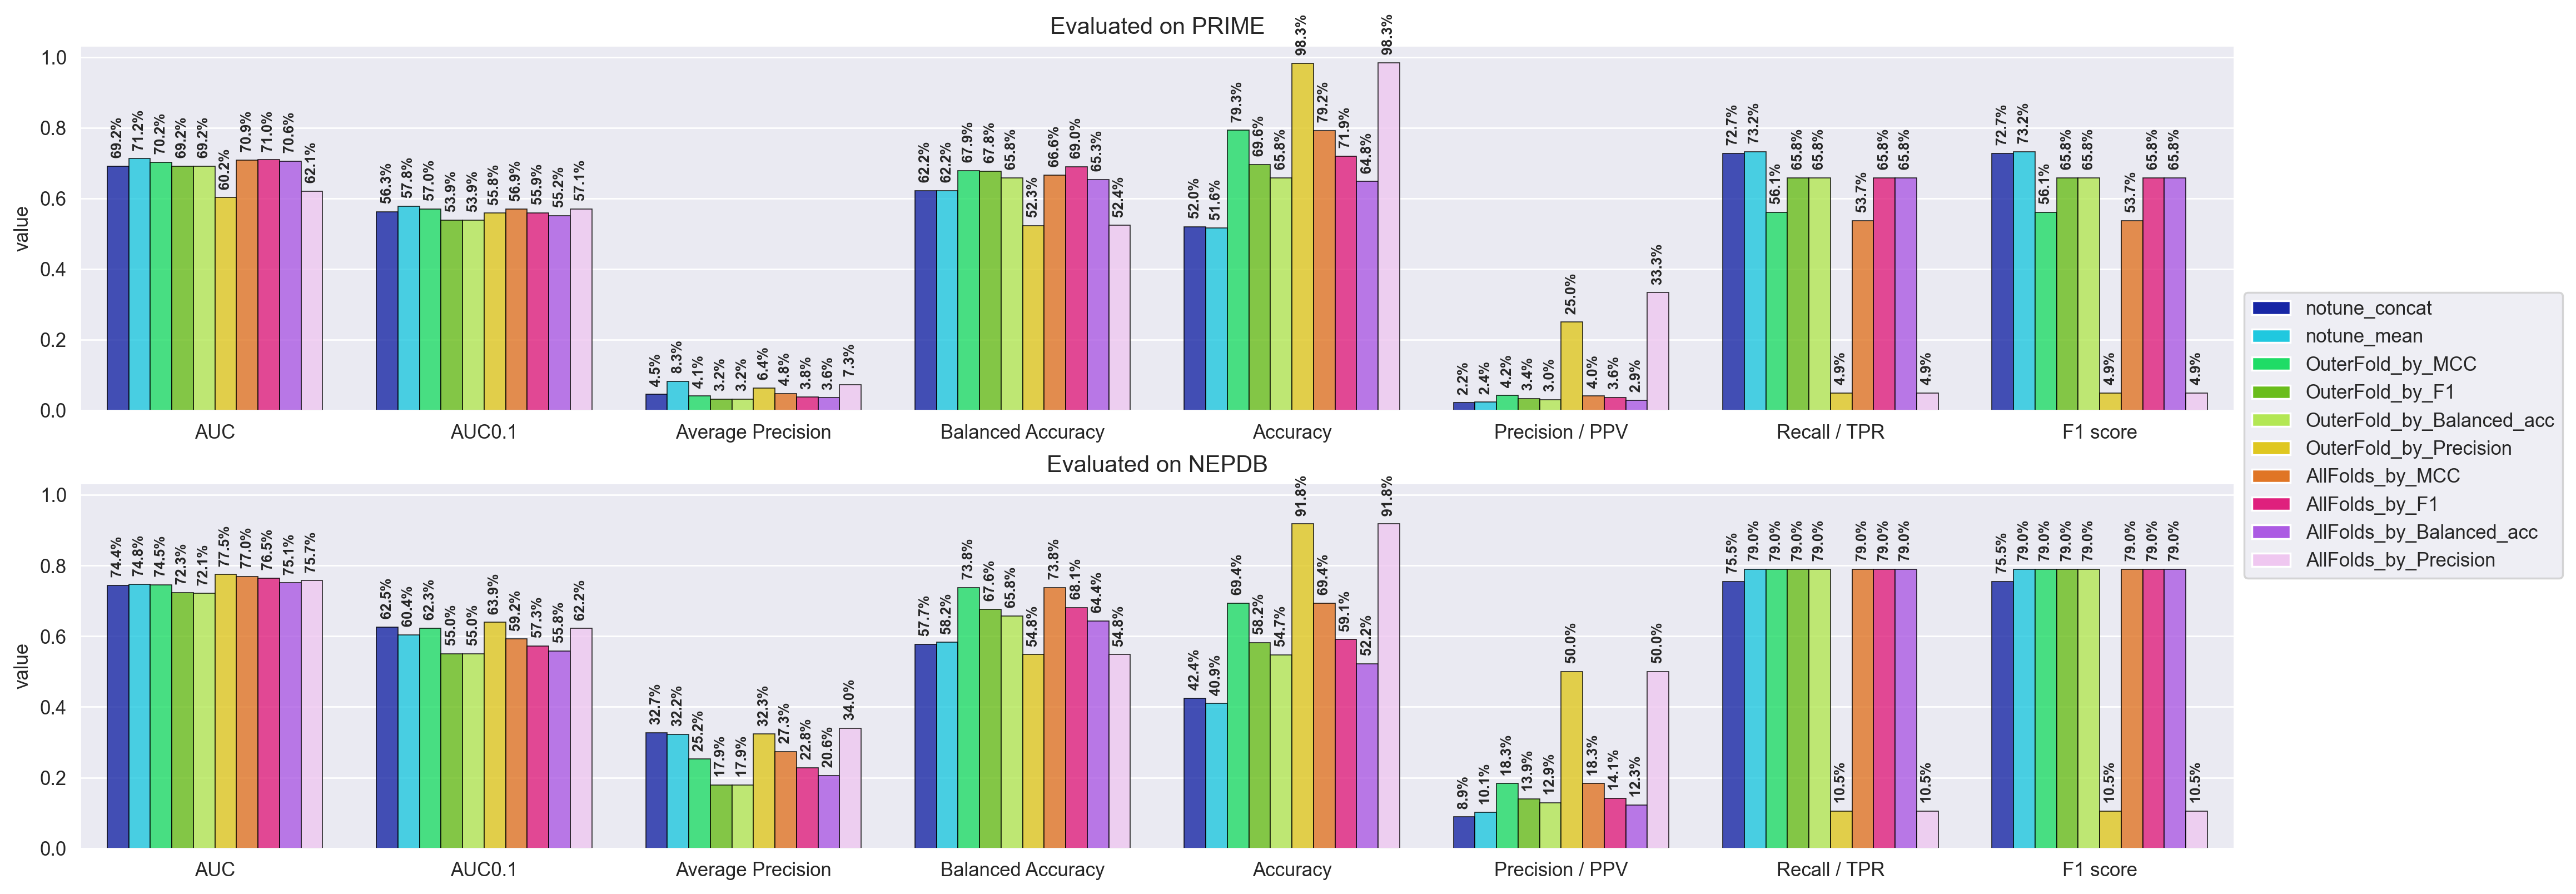

In [53]:
from src.utils import get_palette
rename_map = {'ap':'Average Precision', 'balanced_acc':'Balanced Accuracy', 'acc':'Accuracy',
              'prec':'Precision / PPV', 'rec':'Recall / TPR', 'f1':'F1 score', 'auc':'AUC', 'auc01':'AUC0.1'}
def rename_metric(metric):
    return rename_map[metric]

mpl.rcParams['figure.dpi'] = 250
results_df = pd.concat([pd.DataFrame(results_prime).T.assign(evalset='PRIME'), pd.DataFrame(results_nepdb).T.assign(evalset='NEPDB')]).reset_index().rename(columns={'index':'Method'})
f,a = plt.subplots(2,1, figsize=(20,7.5), sharey=True)
for evalset, axis in zip(results_df.evalset.unique(), a.ravel()):
    tmp = results_df.query('evalset==@evalset').melt(id_vars = ['evalset','Method'], value_vars = [x for x in results_df.columns if x!='Method' and x!='evalset'])
    tmp['variable'] = tmp['variable'].apply(rename_metric)
    sns.barplot(data=tmp, y='value', x='variable', hue='Method', errorbar=None, ax=axis, palette=get_palette('gist_ncar', n_colors=len(results_nepdb.keys())))
    if evalset=='NEPDB':
        axis.legend([], frameon=False)
    else:
        axis.legend(bbox_to_anchor = (1.,.35))
    plt.setp(axis.patches, linewidth=0.5, edgecolor='k', alpha=0.8)
    axis.set_xlabel(None)
    axis.set_title(f'Evaluated on {evalset}')    
    for container in axis.containers:
        values = [f'  {x:.1%}' for x in container.datavalues]
        axis.bar_label(container, labels=values, fontsize=7.5, fontweight='semibold', rotation=90)
f.savefig('../../../writing/threshold_tuning.png') 

## checks from preds / prev results

In [81]:
gb_merged=pd.read_csv('../output/230125_aligned_icore_exprscore_mutscore/gb_merged.csv')
gb_merged.set_index(['encoding','weight', 'key','pep_col'], inplace=True)

In [56]:
gb_merged.sort_values('mean_precision_PRIME', ascending=False).head()

experiment  \
encoding weight  key                                                pep_col                            
onehot   Shannon Total Gene TPM                                     icore_mut  aligned_expr_mutscore   
         None    Total Peptide TPM                                  icore_mut  aligned_expr_mutscore   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut  aligned_expr_mutscore   
                 core_mutation_score-Total Gene TPM                 icore_mut   normal_expr_mutscore   
                 icore_mut_score-Total Gene TPM                     icore_mut  aligned_expr_mutscore   

                                                                               mean_auc_CEDAR  \
encoding weight  key                                                pep_col                     
onehot   Shannon Total Gene TPM                                     icore_mut        0.727530   
         None    Total Peptide TPM                                  icore_mut        0.725230   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut        0.727256   
                 core_mutation_score-Total Gene TPM                 icore_mut        0.726925   
                 icore_mut_score-Total Gene TPM                     icore_mut        0.727225   

                                                                               mean_precision_CEDAR  \
encoding weight  key                                                pep_col                           
onehot   Shannon Total Gene TPM                                     icore_mut              0.876059   
         None    Total Peptide TPM                                  icore_mut              0.503176   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut              0.999700   
                 core_mutation_score-Total Gene TPM                 icore_mut              1.000000   
                 icore_mut_score-Total Gene TPM                     icore_mut              0.999900   

                                                                               mean_auc_PRIME  \
encoding weight  key                                                pep_col                     
onehot   Shannon Total Gene TPM                                     icore_mut        0.696006   
         None    Total Peptide TPM                                  icore_mut        0.695849   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut        0.701861   
                 core_mutation_score-Total Gene TPM                 icore_mut        0.693879   
                 icore_mut_score-Total Gene TPM                     icore_mut        0.691749   

                                                                               mean_precision_PRIME  \
encoding weight  key                                                pep_col                           
onehot   Shannon Total Gene TPM                                     icore_mut                0.6311   
         None    Total Peptide TPM                                  icore_mut                0.6311   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut                0.6311   
                 core_mutation_score-Total Gene TPM                 icore_mut                0.6311   
                 icore_mut_score-Total Gene TPM                     icore_mut                0.6311   

                                                                               mean_auc_IBEL  \
encoding weight  key                                                pep_col                    
onehot   Shannon Total Gene TPM                                     icore_mut       0.526269   
         None    Total Peptide TPM                                  icore_mut       0.519655   
         Shannon icore_dissimilarity_score-icore_mut_score-Total... icore_mut       0.554426   
                 core_mutation_score-Total Gene TPM                 icore_mut

In [57]:
gb_merged.sort_values('Compromise', ascending=False).head()

experiment  \
encoding weight        key                                                pep_col                            
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut  aligned_expr_mutscore   

                                                                                     mean_auc_CEDAR  \
encoding weight        key                                                pep_col                     
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.727096   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.728096   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.727685   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.726988   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.726896   

                                                                                     mean_precision_CEDAR  \
encoding weight        key                                                pep_col                           
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.574228   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.430404   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.503432   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.668514   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.728557   

                                                                                     mean_auc_PRIME  \
encoding weight        key                                                pep_col                     
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.715249   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712474   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712129   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712271   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut        0.712369   

                                                                                     mean_precision_PRIME  \
encoding weight        key                                                pep_col                           
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.000000   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.630900   
         Inverted Mask icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.435577   
                       icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut              0.435577   

                                                                                     mean_auc_IBEL  \
encoding weight        key                                                pep_col                    
onehot   None          icore_dissimilarity_score-icore_blsm_mut_score-... icore_mut       0.558364   
                       icore_dissimilarity_scor

In [63]:
%ls ../output/230125_aligned_icore_exprscore_mutscore/raw/ | grep "CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM" | head

CEDAR_preds_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM.csv


In [61]:
cdt_comp = '_cedar_onehot_None_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_blsm_mut_score-Total Gene TPM'
cdt_prime_prec = '_cedar_onehot_Shannon_icore_mut_EL_rank_mut_icore_dissimilarity_score-icore_mut_score-Total Scaled Peptide TPM'

In [64]:
dir_ = '../output/230125_aligned_icore_exprscore_mutscore/raw/'
cedar_preds_comp = pd.read_csv(f'{dir_}CEDAR_preds{cdt_comp}.csv')
prime_preds_comp = pd.read_csv(f'{dir_}PRIME_preds{cdt_comp}.csv')
nepdb_preds_comp = pd.read_csv(f'{dir_}NEPDB_preds{cdt_comp}.csv')

cedar_preds_prime_prec = pd.read_csv(f'{dir_}CEDAR_preds{cdt_prime_prec}.csv')
prime_preds_prime_prec = pd.read_csv(f'{dir_}PRIME_preds{cdt_prime_prec}.csv')
nepdb_preds_prime_prec = pd.read_csv(f'{dir_}NEPDB_preds{cdt_prime_prec}.csv')



In [78]:
res = {}
for preds, name in zip([cedar_preds_comp,prime_preds_comp,nepdb_preds_comp,cedar_preds_prime_prec,prime_preds_prime_prec,nepdb_preds_prime_prec],
                       ['cedar_compromise', 'prime_compromise', 'nepdb_compromise', 'cedar_PP', 'prime_PP', 'nepdb_PP']):
    c = 'mean_pred' if 'mean_pred' in preds.columns else 'pred'
    for t in [0.5, 0.19]:
        sc, _ = get_scores(preds[c], preds['agg_label'], t)
        res[f'{name}_{t}'] = sc
comparison_df = pd.DataFrame(res).T
comparison_df.columns = map(rename_metric, comparison_df.columns)
comparison_df

,AUC,AUC0.1,Average Precision,Balanced Accuracy,Accuracy,Precision / PPV,Recall / TPR,F1 score
cedar_compromise_0.5,0.7279,0.5767,0.4153,0.5016,0.7912,0.4286,0.0048,0.0048
cedar_compromise_0.19,0.7279,0.5767,0.4153,0.6617,0.5974,0.3119,0.7721,0.7721
prime_compromise_0.5,0.7125,0.5780,0.0827,0.5000,0.9842,0.0000,0.0000,0.0000
prime_compromise_0.19,0.7125,0.5780,0.0827,0.6221,0.5160,0.0236,0.7317,0.7317
nepdb_compromise_0.5,0.7475,0.6035,0.3220,0.5000,0.9181,0.0000,0.0000,0.0000
nepdb_compromise_0.19,0.7475,0.6035,0.3220,0.5825,0.4095,0.1014,0.7895,0.7895
cedar_PP_0.5,0.7272,0.5747,0.4185,0.5064,0.7942,1.0000,0.0128,0.0128
cedar_PP_0.19,0.7272,0.5747,0.4185,0.6675,0.6027,0.3162,0.7785,0.7785
prime_PP_0.5,0.7020,0.5857,0.0842,0.5242,0.9846,0.6667,0.0488,0.0488
prime_PP_0.19,0.7020,0.5857,0.0842,0.6377,0.5230,0.0247,0.7561,0.7561


In [82]:
prime_preds_prime_prec.loc[[678, 679],['Peptide', 'trueHLA_EL_rank']]

,Peptide,trueHLA_EL_rank
678,GLFGDIYLA,0.0523
679,GLFGDIYLAI,0.3693


In [80]:
prime_preds_prime_prec.sort_values('mean_pred', ascending=False).head(10)

,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,len,EL_rank_mut,EL_rank_wt,...,icore_len_wt,icore_anchor,icore_mutation_position,icore_anchor_mutation,icore_mut_score,icore_blsm_mut_score,Total Peptide TPM,Total Scaled Peptide TPM,Total Gene TPM,mean_pred
678,HLA-A0201,0,3,GLFGDIYLA,GSFGDIYLA,GLFGDIYLA,GLFGDIYLA,9,0.0523,2.8567,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.82140,0.530747
679,HLA-A0201,1,3,GLFGDIYLAI,GSFGDIYLAI,GLFGDIYLA,GLFGDIYLA,10,0.0523,2.8567,...,9,"1,3,8",1,True,2,-2,87.821,60.421,87.82140,0.530747
101,HLA-A0201,1,2,ALYGFVPVLL,ALYGSVPVLL,ALYGFVPVL,ALYGFVPVL,10,0.0216,0.0257,...,9,"1,3,8",4,False,2,-2,155.827,77.914,155.82700,0.521443
525,HLA-A0201,0,1,FLQKYTVKL,FLQEYTVKL,FLQKYTVKL,FLQKYTVKL,9,0.0178,0.0026,...,9,"1,3,8",3,True,2,1,18.762,14.072,18.76150,0.478368
2514,HLA-A0201,0,6,YLSPFMIVI,YLSPSMIVI,YLSPFMIVI,YLSPFMIVI,9,0.0641,0.0894,...,9,"1,3,8",4,False,2,-2,5.681,5.681,5.68082,0.468965
903,HLA-A0201,0,1,ILFLIISYVA,ILFLIISSVA,ILFLIISYV,ILFLIISYV,10,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
902,HLA-A0201,0,1,ILFLIISYV,ILFLIISSV,ILFLIISYV,ILFLIISYV,9,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
905,HLA-A0201,0,1,SILFLIISYVA,SILFLIISSVA,ILFLIISYV,ILFLIISYV,11,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
904,HLA-A0201,0,1,SILFLIISYV,SILFLIISSV,ILFLIISYV,ILFLIISYV,10,0.3216,0.2391,...,9,"1,3,8",7,False,2,-2,0.001,0.001,0.00100,0.457581
417,HLA-B3501,0,5,FALDITNLMPL,FSLDITNLMPL,FALDITNLM,FALDITNLM,11,0.1046,0.5669,...,9,"1,8",1,True,4,1,0.001,0.001,0.00100,0.444470


# Thresholding with Z-score?

In [98]:
import math
(cedar_expr.groupby('len').agg(count=('Peptide','count'))/len(cedar_expr) * 100000).apply(math.ceil, axis=1)

len
9     50536
10    28816
11    20583
12       67
dtype: int64